# Latent Variable Implementation

The `gp.Latent` class is a direct implementation of a GP.  It is called "Latent" because the underlying function values are treated as latent variables.  It has a `prior` method, and a `conditional` method.  Given a mean and covariance function, the function $f(x)$ is modeled as,

$$
f(x) \sim \mathcal{GP}(m(x),\, k(x, x')) \,.
$$

## `.prior`

With some data set of finite size, the `prior` method places a multivariate normal prior distribution on the vector of function values, $\mathbf{f}$,

$$
\mathbf{f} \sim \text{MvNormal}(\mathbf{m}_{x},\, \mathbf{K}_{xx}) \,,
$$

where the vector $\mathbf{m}$ and the matrix $\mathbf{K}_{xx}$ are the mean vector and covariance matrix evaluated over the inputs $x$.  Some sample code is,

```python
import numpy as np
import pymc3 as pm

# A one dimensional column vector of inputs.
X = np.linspace(0, 1, 10)[:,None]

with pm.Model() as latent_gp_model:
    # Specify the covariance function.
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.1)
    
    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Latent(cov_func=cov_func)
    
    # Place a GP prior over the function f.
    f = gp.prior("f", X=X)
```

By default, PyMC3 reparameterizes the prior on `f` under the hood by rotating it with the Cholesky factor of its covariance matrix.  This helps to reduce covariances in the posterior of the transformed random variable, `v`.  The reparameterized model is,

$$
\begin{aligned}
  \mathbf{v} \sim \text{N}(0, 1)& \\
  \mathbf{L} = \text{Cholesky}(\mathbf{K}_{xx})& \\
  \mathbf{f} = \mathbf{m}_{x} + \mathbf{Lv} \\
\end{aligned}
$$

For more information about this reparameterization, see the section on [drawing values from a multivariate distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Drawing_values_from_the_distribution).  This reparameterization can be disabled by setting the optional flag in the `prior` method, `reparameterize = False`.  The default is `True`.

## `.conditional`

The conditional method implements the predictive distribution for function values that were not part of the original data set.  This distribution is,

$$
\mathbf{f}_* \mid \mathbf{f} \sim \text{MvNormal} \left(
  \mathbf{m}_* + \mathbf{K}_{*x}\mathbf{K}_{xx}^{-1} \mathbf{f} ,\,
  \mathbf{K}_{**} - \mathbf{K}_{*x}\mathbf{K}_{xx}^{-1}\mathbf{K}_{x*} \right)
$$

Using the same `gp` object we defined above, we can construct a random variable with this
distribution by,

```python
# vector of new X points we want to predict the function at
X_star = np.linspace(0, 2, 100)[:, None]

with latent_gp_model:
    f_star = gp.conditional("f_star", X_star)
```

## Example 1: Regression with Student-T distributed noise

The following is an example showing how to specify a simple model with a GP prior using the `gp.Latent` class.  So we can verify that the inference we perform is correct, the data set is made using a draw from a GP.  

In [1]:
import sys

import pymc3 as pm
import theano.tensor as tt
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

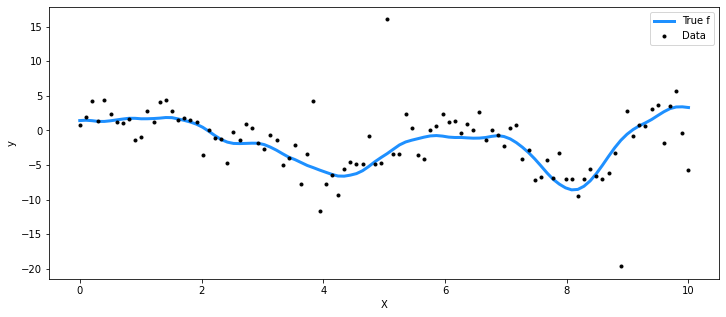

In [2]:
# set the seed
np.random.seed(1)

n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(), 
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
σ_true = 2.0
ν_true = 3.0
y = f_true + σ_true * np.random.standard_t(ν_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

The data above shows the observations, marked with black dots, of the unknown function $f(x)$ that has been corrupted by noise.  The true function is in blue.  

### Coding the model in PyMC3

Here's the model in PyMC3.  We use a $\text{Gamma}(2, 1)$ prior over the lengthscale parameter, and weakly informative $\text{HalfCauchy}(5)$ priors over the covariance function scale, and noise scale.  A $\text{Gamma}(2, 0.1)$ prior is assigned to the degrees of freedom parameter of the noise.  Finally, a GP prior is placed on the unknown function.  For more information on choosing priors in Gaussian process models, check out some of [recommendations by the Stan folks](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations).

In [3]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    
    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    
    f = gp.prior("f", X=X)
    
    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0/σ, nu=ν, observed=y)
    
    trace = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/env/miniconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/env/miniconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/env/miniconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(s

/env/miniconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 599 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


### Results

Below are the posteriors of the covariance function hyperparameters.  The red lines show the true values that were used to draw the function from the GP.

/dependencies/arviz/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


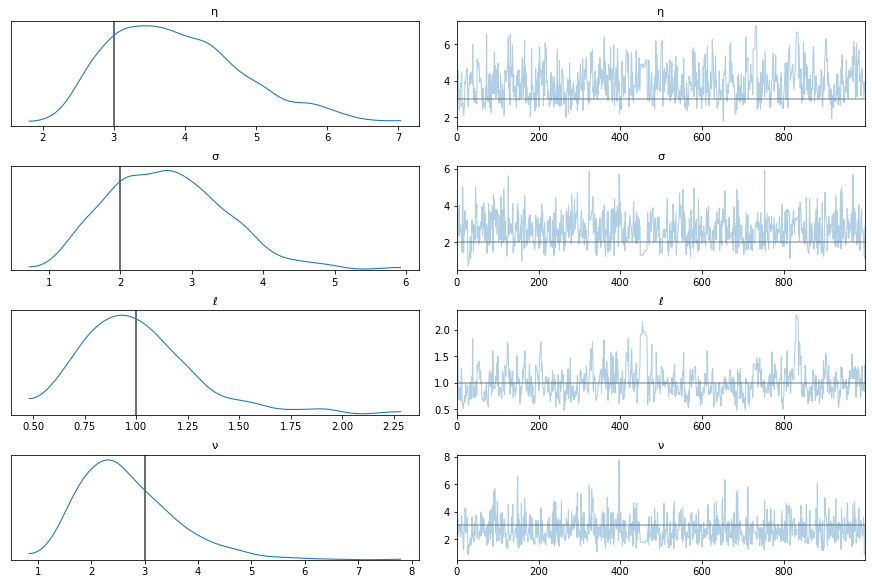

In [4]:
lines = [
    ("η",  {}, η_true), 
    ("σ", {}, σ_true), 
    ("ℓ", {}, ℓ_true),
    ("ν", {}, ν_true),
]
pm.traceplot(trace, lines=lines, var_names=["η", "σ", "ℓ", "ν"]);

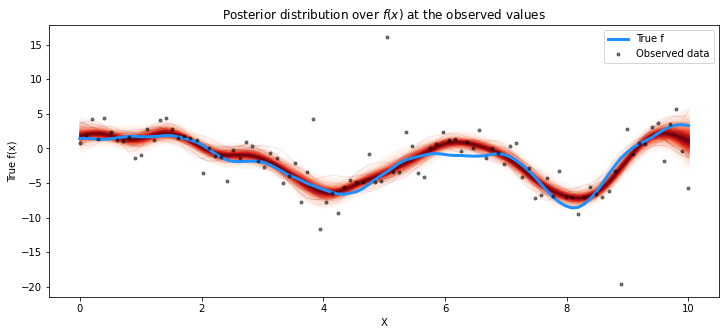

In [5]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, trace["f"], X);

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)"); 
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

As you can see by the red shading, the posterior of the GP prior over the function does a great job of representing both the fit, and the uncertainty caused by the additive noise.  The result also doesn't over fit due to outliers from the Student-T noise model.

### Using `.conditional`

Next, we extend the model by adding the conditional distribution so we can predict at new $x$ locations.  Lets see how the extrapolation looks out to higher $x$.  To do this, we extend our `model` with the `conditional` distribution of the GP.  Then, we can sample from it using the `trace` and the `sample_posterior_predictive` function.  This is similar to how Stan uses its `generated quantities {...}` blocks.  We could have included `gp.conditional` in the model *before* we did the NUTS sampling, but it is more efficient to separate these steps.

In [6]:
# 200 new values from x=0 to x=15
n_new = 200
X_new = np.linspace(0, 15, n_new)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)

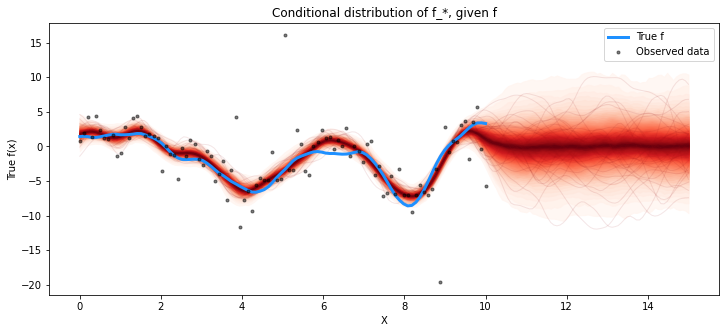

In [7]:
# plot the results

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new);
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Conditional distribution of f_*, given f"); plt.legend();

## Example 2: Classification

First we use a GP to generate some data that follows a Bernoulli distribution, where $p$, the probability of a one instead of a zero is a function of $x$. 

In [8]:
np.random.seed(1)

# number of data points
n = 200

# x locations
x = np.linspace(0, 1.5, n)

# true covariance
ℓ_true = 0.1
η_true = 1.0
cov_func = η_true**2 * pm.gp.cov.ExpQuad(1, ℓ_true)
K = cov_func(x[:,None]).eval()

# zero mean function
mean = np.zeros(n)

# sample from the gp prior
f_true = np.random.multivariate_normal(mean, K + 1e-6 * np.eye(n), 1).flatten()

# link function
def invlogit(x, eps=sys.float_info.epsilon):
    return (1.0 + 2.0 * eps) / (1.0 + np.exp(-x)) + eps

y = pm.Bernoulli.dist(p=invlogit(f_true)).random()

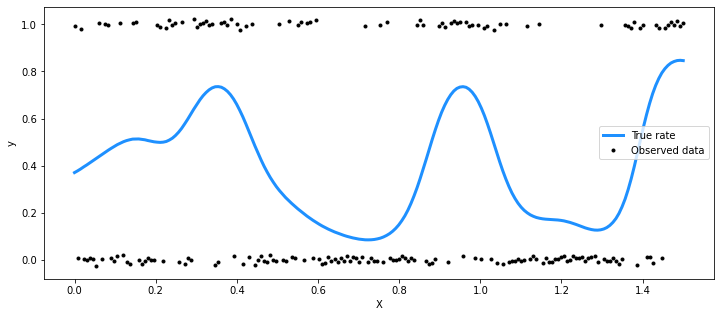

In [9]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(x, invlogit(f_true), 'dodgerblue', lw=3, label="True rate");
ax.plot(x, y + np.random.randn(n)*0.01, 'ko', ms=3, label="Observed data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

In [10]:
with pm.Model() as model:
    # covariance function
    ℓ = pm.Gamma("ℓ", alpha=2, beta=2)
    # informative, positive normal prior on the period 
    η = pm.HalfNormal("η", sigma=5)
    cov = η**2 * pm.gp.cov.ExpQuad(1, ℓ)
    
    gp = pm.gp.Latent(cov_func=cov)
    
    # make gp prior
    f = gp.prior("f", X=x[:,None])
    
    # logit link and Bernoulli likelihood
    p = pm.Deterministic("p", pm.math.invlogit(f))
    y_ = pm.Bernoulli("y", p=p, observed=y)
    
    trace = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/env/miniconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/env/miniconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, η, ℓ]


/env/miniconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 726 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43706382286861767, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


/dependencies/arviz/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


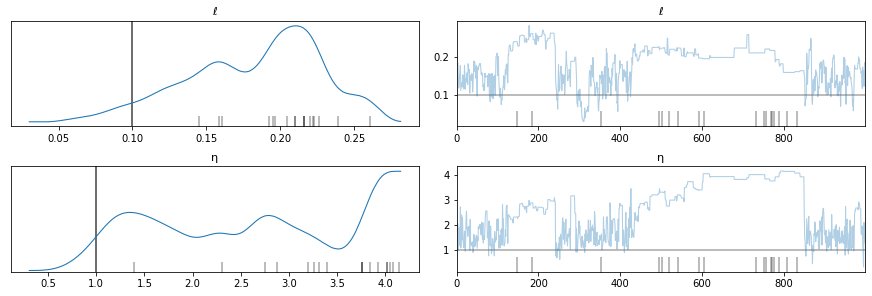

In [11]:
pm.traceplot(trace, var_names=['ℓ', 'η'], lines=[("ℓ", {}, ℓ_true), ("η", {}, η_true)]);

In [12]:
n_pred = 200
X_new = np.linspace(0, 2.0, n_pred)[:,None]

with model:
    f_pred = gp.conditional("f_pred", X_new)

with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)

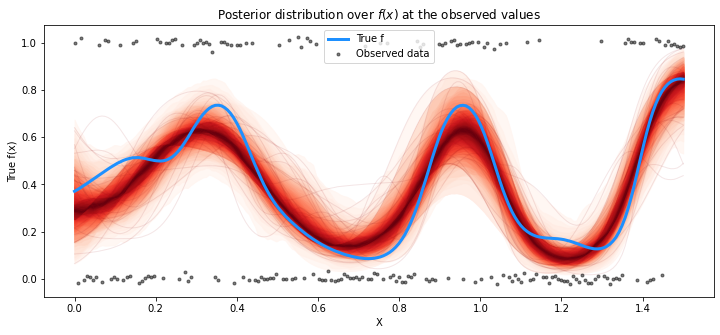

In [13]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, invlogit(trace["f"]), x);

# plot the data (with some jitter) and the true latent function
plt.plot(x, invlogit(f_true), "dodgerblue", lw=3, label="True f");
plt.plot(x, y + np.random.randn(y.shape[0])*0.01, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)"); 
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w

pymc3 3.9.0
numpy 1.18.5
last updated: Mon Jun 15 2020 

CPython 3.7.7
IPython 7.15.0
watermark 2.0.2
